### Notes  

I'll move the functions to a module later. This is a work in progress. Have been trying to figure out how best to pass a neural network my data. Maybe a list of sub eegs can be passed. So each item in the list is a matrix which is passed to the neural network. If I remember correctly, this is how things worked with the handwritten digit recognition. The other option is stacking the EEGs but that makes the target variable more difficult to use because I'd have to assign a value to each row of the EEG data. Each sub eeg has a y value associated with it and each sub eeg has 10k rows. So instead of 1 y value for a set of 10k rows, often with these sets overlapping significantly, I'd have 1 y value for each individual row of eeg data.

In [48]:
import pandas as pd
import numpy as np
import pyarrow
import matplotlib.pyplot as plt

In [49]:
train = pd.read_csv('train.csv')

In [50]:
train

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0


In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
eeg1 = pd.read_parquet('train_eegs/351917269.parquet', engine = 'pyarrow')

In [6]:
pd.isnull(eeg1).sum().sum()

0

In [7]:
def check_nulls(eeg):
    total = eeg.shape[0] * eeg.shape[1]
    nulls = pd.isnull(eeg).sum().sum()
    return nulls / total

In [8]:
def get_eeg(eegID):
    return pd.read_parquet('train_eegs/{}.parquet'.format(eegID), engine = 'pyarrow')

In [30]:
def replace_nulls(eeg):
    for col in eeg.columns:
        if pd.isnull(eeg).sum().sum() > 0:
            eeg[col].fillna(eeg[col].median(), inplace = True)
    return eeg

def preprocess(eeg):
    eeg = replace_nulls(eeg)
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(eeg), columns = eeg.columns)

First step is visualization. That doesn't work very well with the EEG data, but I'll do what I did last time and plot each activity type together in a grid. Each column will be a sub EEG of a different activity type.

The only function I need to pull from the other notebook for this is get_sub_eeg function.  

After visualization, I can get the data ready and start building a model. I wrote simple functions for that above. I'll get rid of EEGs with too many null values and then scale the rest. Then the plan is to stack EEGs and create a list of the activity type corresponding with each row. This isn't going to be perfect since the sub EEGs are what are categorized, not the individual rows, but it will line up for the most part. Not sure how else to go about this in as way that would feed into a neural network since the EEG data is split between 17k different parquets. Stacking this way seems the best.

In [31]:
def get_sub_eeg(data, row):
    eeg_id = data['eeg_id'][row]
    eeg = pd.read_parquet('train_eegs/{}.parquet'.format(eeg_id), engine = 'pyarrow')
    first_row = data['eeg_label_offset_seconds'][row] * 200
    first_row = int(first_row)
    last_row = first_row + 10000
    sub_eeg = eeg.iloc[first_row: last_row].reset_index()
    sub_eeg = sub_eeg.drop(columns = 'index')
    return sub_eeg

In [32]:
other_i = np.where(train[train['expert_consensus'] == 'Other'])[0]
lpd_i = np.where(train[train['expert_consensus'] == 'LPD'])[0]
gpd_i = np.where(train[train['expert_consensus'] == 'GPD'])[0]
lrda_i = np.where(train[train['expert_consensus'] == 'LRDA'])[0]
grda_i = np.where(train[train['expert_consensus'] == 'GRDA'])[0]
seizure_i = np.where(train[train['expert_consensus'] == 'Seizure'])[0]

In [22]:
import random as rnd

In [26]:
i1 = rnd.choice(other_i)
i2 = rnd.choice(lpd_i)
i3 = rnd.choice(gpd_i)
i4 = rnd.choice(lrda_i)
i5 = rnd.choice(grda_i)
i6 = rnd.choice(seizure_i)

In [27]:
i1, i2, i3, i4, i5, i6

(7242, 10006, 8629, 5628, 9120, 4016)

In [33]:
other_sub = preprocess(get_sub_eeg(train, i1))
lpd_sub = preprocess(get_sub_eeg(train, i2))
gpd_sub = preprocess(get_sub_eeg(train, i3))
lrda_sub = preprocess(get_sub_eeg(train, i4))
grda_sub = preprocess(get_sub_eeg(train, i5))
seizure_sub = preprocess(get_sub_eeg(train, i6))

Below is one grid of sub eeg plots. Each column is an activity type. The activity types from left to right are Other, LPD, GPD, LRDA, GRDA, and Seizure. The rows correspond to the electrode locations which are the sub eeg columns. For example, the first row is for the first electrode at the prefrontal cortex. EEG data is very noisy, so these plots don't show much. The trends shown here don't hold for each individual sub eeg.

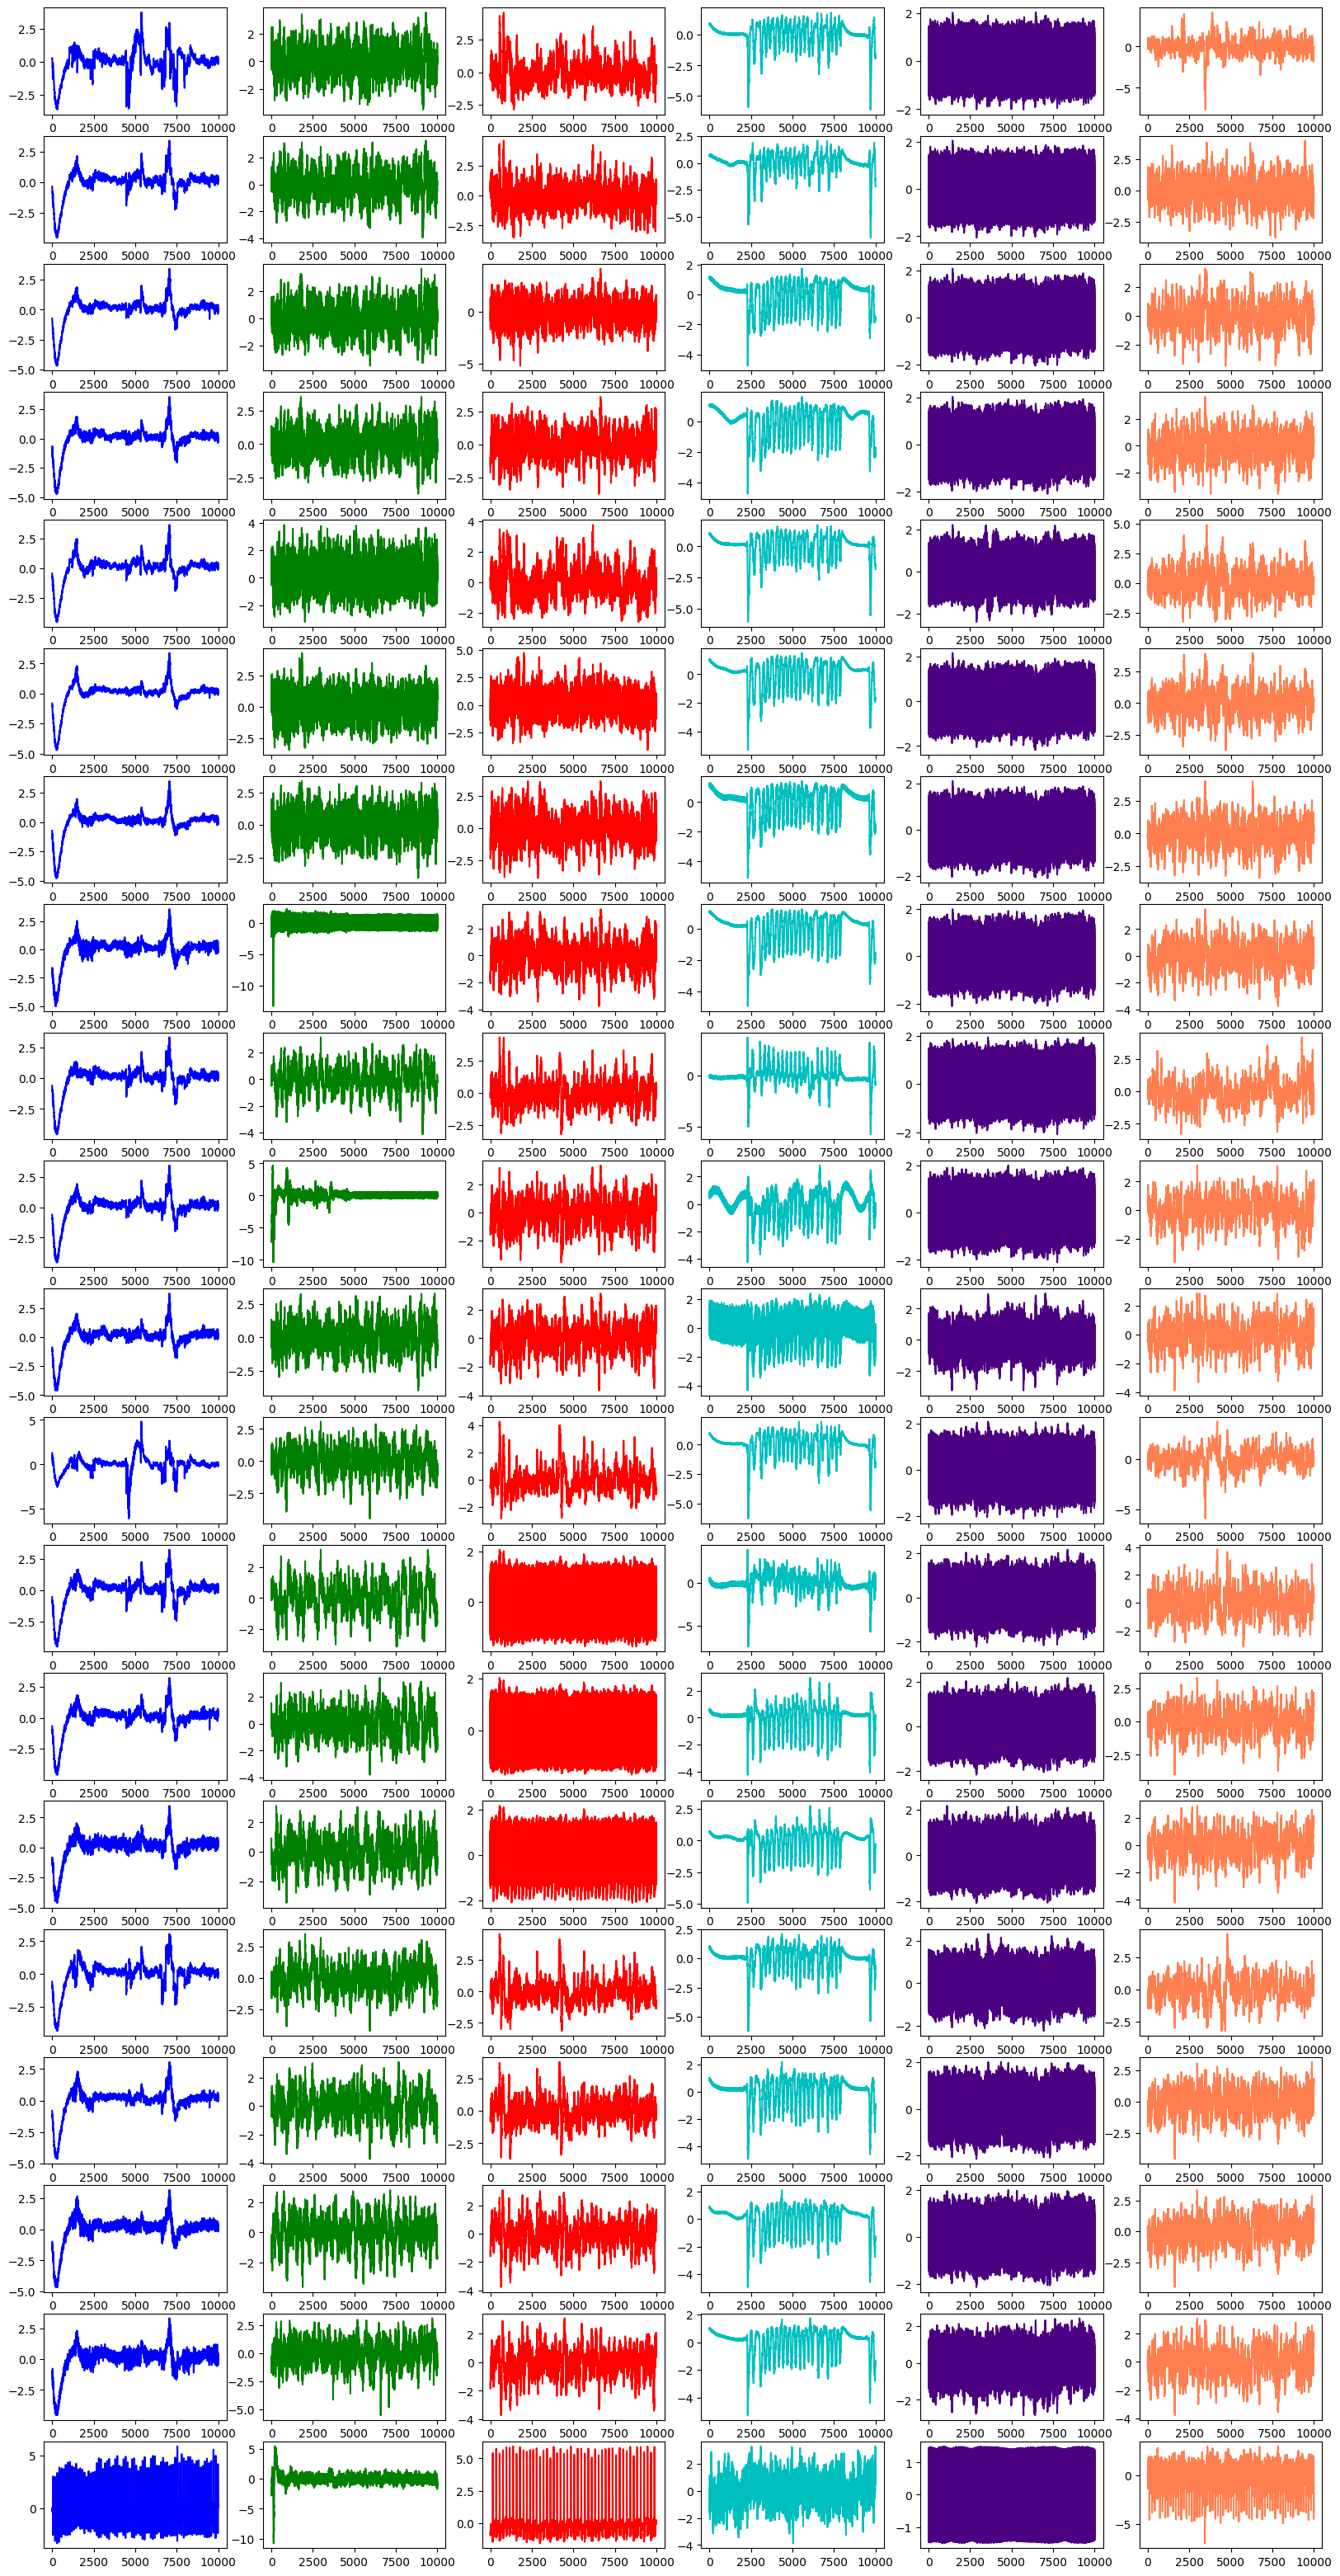

In [37]:
col_list = other_sub.columns
eeg_list = [other_sub, lpd_sub, gpd_sub, lrda_sub, grda_sub, seizure_sub]
colors = ['b', 'g', 'r', 'c', 'indigo', 'coral']
fig, axs = plt.subplots(20, 6)
fig.set_figheight(40)
fig.set_figwidth(20)
for i in range(len(col_list)):
    for j in range(len(eeg_list)):
        axs[i][j].plot(eeg_list[j][col_list[i]], color = colors[j])
        
plt.show()

In [44]:
eeg_ids = np.unique(train.eeg_id)

In [45]:
eeg_ids

array([    568657,     582999,     642382, ..., 4294455489, 4294858825,
       4294958358])